# 03 — Classification Modelling
Mục tiêu: train mô hình phân lớp AQI (6 lớp), split theo thời gian, đánh giá bằng accuracy + macro-F1, confusion matrix, và lưu metrics/prediction sample.

In [2]:
DATASET_PATH = 'data/processed/dataset_for_clf.parquet'
CUTOFF = '2017-01-01'
METRICS_PATH = 'data/processed/metrics.json'
PRED_SAMPLE_PATH = 'data/processed/predictions_sample.csv'


In [3]:
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- ĐOẠN FIX LỖI ĐƯỜNG DẪN (PATH) ---
PROJECT_ROOT = Path('.').resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
# -------------------------------------

from src.classification_library import time_split, train_classifier, AQI_CLASSES

# 1. Định nghĩa các đường dẫn (Đảm bảo khớp với file semi_labeled_data.parquet bạn vừa lưu)
DATASET_PATH = "data/processed/semi_labeled_data.parquet"
METRICS_PATH = "data/runs/metrics_supervised_baseline.json"
PRED_SAMPLE_PATH = "data/runs/pred_supervised_baseline.parquet"

dataset_path = (PROJECT_ROOT / DATASET_PATH).resolve()
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()

metrics_path.parent.mkdir(parents=True, exist_ok=True)
pred_path.parent.mkdir(parents=True, exist_ok=True)

# 2. Đọc dữ liệu bán giám sát
df = pd.read_parquet(dataset_path)

# 3. Chỉ lấy phần dữ liệu CÓ NHÃN trong tập Train để làm Baseline
# Theo tài liệu: Supervised baseline sử dụng tập dữ liệu có nhãn ban đầu (nhỏ) [cite: 53]
df_labeled = df[df['is_labeled'] == True].copy()

print(f"Tổng số dòng dữ liệu: {len(df)}")
print(f"Số dòng dùng để huấn luyện Baseline (Có nhãn): {len(df_labeled)}")

Tổng số dòng dữ liệu: 420768
Số dòng dùng để huấn luyện Baseline (Có nhãn): 95924


In [4]:
df = pd.read_parquet(dataset_path)
print('shape:', df.shape)
df[['datetime','station','aqi_class']].head()

shape: (420768, 36)


,datetime,station,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,None
1,2013-03-01 01:00:00,Aotizhongxin,None
2,2013-03-01 02:00:00,Aotizhongxin,None
3,2013-03-01 03:00:00,Aotizhongxin,None
4,2013-03-01 04:00:00,Aotizhongxin,None


In [5]:
train_df, test_df = time_split(df, cutoff=CUTOFF)
print('train:', train_df.shape, '| test:', test_df.shape)
print('test date range:', test_df['datetime'].min(), '->', test_df['datetime'].max())

train: (403776, 36) | test: (16992, 36)
test date range: 2017-01-01 00:00:00 -> 2017-02-28 23:00:00


In [6]:
out = train_classifier(train_df, test_df, target_col='aqi_class')
metrics = out['metrics']
pred_df = out['pred_df']

print('Accuracy:', metrics['accuracy'])
print('F1-macro:', metrics['f1_macro'])
pred_df.head()

Accuracy: 0.5643332733489292
F1-macro: 0.44386808673082756


,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,Hazardous,Hazardous
1,2017-01-01 01:00:00,Aotizhongxin,Hazardous,Hazardous
2,2017-01-01 02:00:00,Aotizhongxin,Hazardous,Hazardous
3,2017-01-01 03:00:00,Aotizhongxin,Hazardous,Hazardous
4,2017-01-01 04:00:00,Aotizhongxin,Hazardous,Hazardous


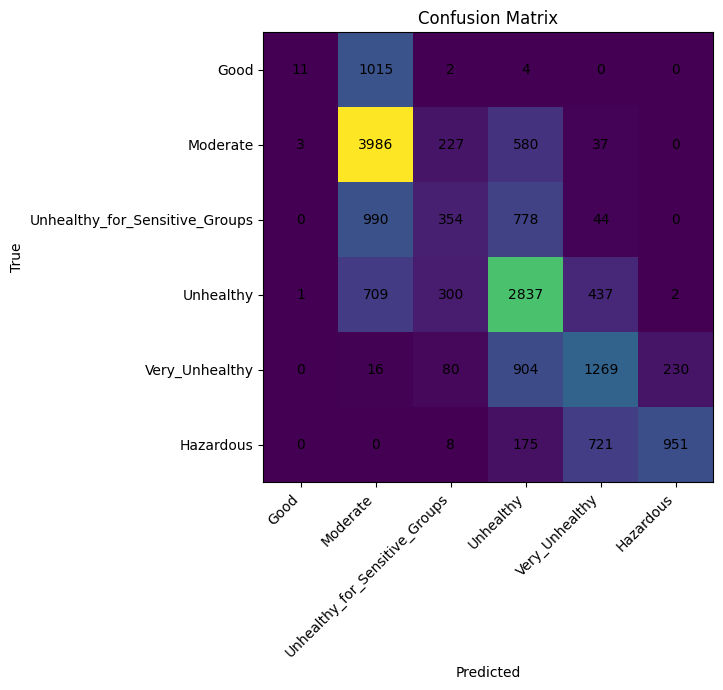

In [7]:
# Confusion matrix plot
cm = np.array(metrics['confusion_matrix'])
labels = metrics['labels']

plt.figure(figsize=(9, 7))
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(int(cm[i, j])), ha='center', va='center')

plt.tight_layout()
plt.show()

In [8]:
# Lưu metrics + sample prediction
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
print('Saved:', metrics_path)
print('Saved:', pred_path)

Saved: D:\air_guard_miniproject\data\runs\metrics_supervised_baseline.json
Saved: D:\air_guard_miniproject\data\runs\pred_supervised_baseline.parquet


In [9]:
# In classification report (rút gọn)
report = metrics['report']
summary = {k: report[k] for k in ['accuracy', 'macro avg', 'weighted avg'] if k in report}
summary

{'accuracy': 0.5643332733489292,
 'macro avg': {'precision': 0.5897995783066609,
  'recall': 0.4468724125628845,
  'f1-score': 0.44386808673082756,
  'support': 16671.0},
 'weighted avg': {'precision': 0.5683122618400437,
  'recall': 0.5643332733489292,
  'f1-score': 0.5289100729005313,
  'support': 16671.0}}

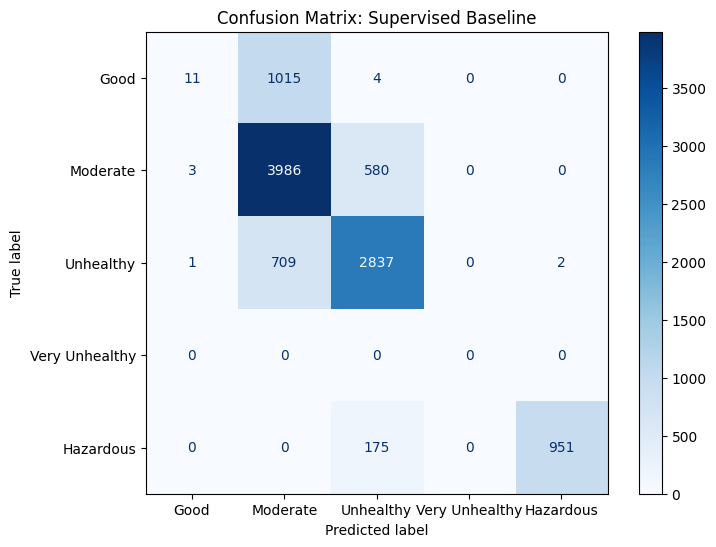

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sử dụng dữ liệu từ pred_df đã có sẵn trong bộ nhớ
y_true = pred_df['y_true']
y_pred = pred_df['y_pred']
labels = ['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

cm = confusion_matrix(y_true, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title("Confusion Matrix: Supervised Baseline")
plt.grid(False)
plt.show()